In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pystan

In [ ]:
#Lets generate some exponentially increasing data
lambd = .2
d = np.random.exponential(scale = 1/lambd, size=1000)
sns.distplot(d)
plt.show()

In [ ]:
code = '''
data {
    int<lower = 0> N;
    real d[N];
}
parameters {
    real beta;
}
model {
    beta ~ normal(-5., .1);
    d ~ exponential(beta);
}

'''
sm = pystan.StanModel(model_code = code, model_name='exp')

In [ ]:
dat = {'N': len(d),
      'd': d}
fit = sm.sampling(data=dat, iter=1500, chains=1)

In [ ]:
fit.plot()
plt.show()

In [ ]:
trace = fit.extract()
lambd = np.median(trace['beta'])
sns.distplot(d)
plt.scatter(d, lambd*np.exp(-d*lambd))


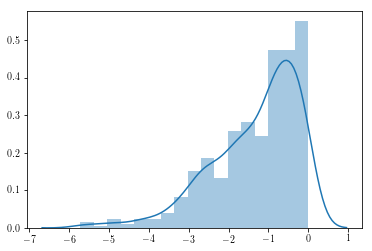

In [2]:
'''Now lets make a gaussian'''
true_m = 1.
true_sig = 2.
d = np.random.normal(true_m,true_sig,size=2000)
d = d[d<0.]
sns.distplot(d)
plt.show()

In [3]:
code = '''
functions {
    real logposexp(real x, real hi, real lo, real lambd) {
        real A;
        A = log(lambd*(exp(lambd*hi)-exp(lambd*lo))^-1);
        return lambd*x + A;
        }
}
data {
    int<lower = 0> N;
    real d[N];
}
parameters {
    real lambd;
}
model {
    lambd ~ normal(0, 1e6);
    for (n in 1:N)
        target += logposexp(d[n], max(d), min(d), lambd);
}

'''
sm = pystan.StanModel(model_code = code, model_name='offgauss')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL offgauss_4220f1ee532b7127dfcfae634a1f2de9 NOW.


In [4]:
dat = {'N': len(d),
      'd': d}
fit = sm.sampling(data=dat, iter=1000, chains=1)

/usr/local/lib/python2.7/dist-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


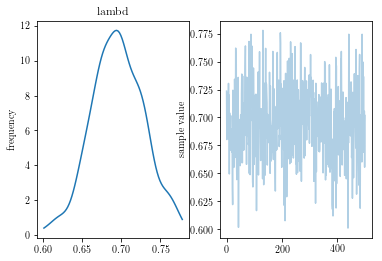

In [5]:
fit.plot()
plt.show()

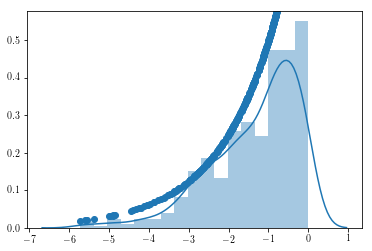

In [6]:
trace = fit.extract()
lambd = np.median(trace['lambd'])
sns.distplot(d)
p = np.exp(lambd*d)
plt.scatter(d,p)

Index([u'#Gc', u'logAge', u'[M/H]', u'm_ini', u'logL', u'logTe', u'logg',
       u'm-M0', u'Av', u'm2/m1', u'mbol', u'U', u'B', u'V', u'R', u'I', u'J',
       u'H', u'K', u'Mact'],
      dtype='object')


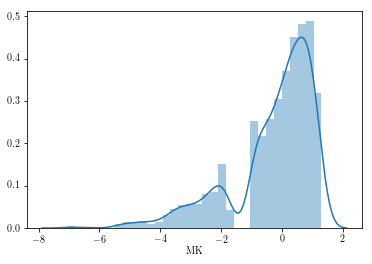

In [33]:
import pandas as pd
sfile = 'file2.txt'
df = pd.read_csv(sfile, sep='\s+')
df.head(5)
print(df.columns)
df['dist'] = 10.0**(df['m-M0'] / 5.0 + 1.0)
df['par'] = 1000.0/df.dist #parallax in mas
df['BV'] = df.B - df.V\
#Make some cuts
df = df.loc[np.abs(df.BV - 0.9) < 0.6]
df = df.loc[df.K > 8.0]
df = df.loc[df.logg < 3.5]
#Calculate absolute magnitude (no extinction)
df['MK'] = df.K - 5.0 * np.log10(df.dist) + 5.0
df1 = df[df.MK < -1.8]
df2 = df[df.MK > -1.]
dfn = pd.concat([df1,df2])
#Plot absolute magnitude in K
sns.distplot(dfn.MK)


In [34]:
dat = {'N': len(df.MK),
      'd': df.MK}
fit = sm.sampling(data=dat, iter=1000, chains=1)

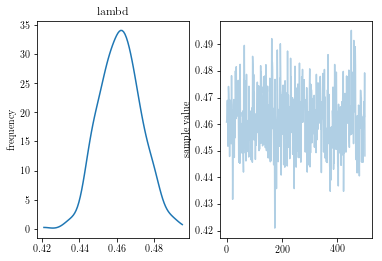

In [35]:
fit.plot()
plt.show()

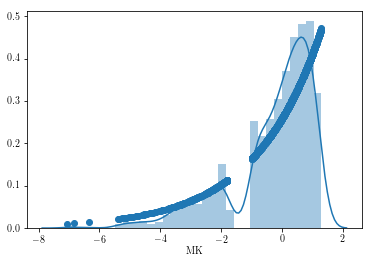

In [39]:
trace = fit.extract()
lambd = np.median(trace['lambd'])
sns.distplot(dfn.MK)
p = (lambd*(np.exp(lambd*dfn.MK.max()) - np.exp(lambd*dfn.MK.min()))**-1)\
                                               *np.exp(lambd*dfn.MK)
plt.scatter(dfn.MK,p)